In [37]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.datasets import load_sample_image
from functools import partial

In [30]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

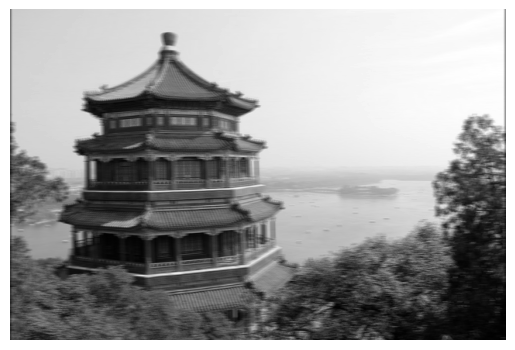

In [3]:
# Load example pictures
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])  # add two pictures to list
batch_size, height, width, channels = images.shape

# Create two filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")  #padding defines put zeros where is no values to make better shape of layer
# when we use VALID it wont add zeros to make better shape of layer

plt.imshow(outputs[0, :, :, 1], cmap="gray") # shows secound map layer of image features
plt.axis("off") 
plt.show()

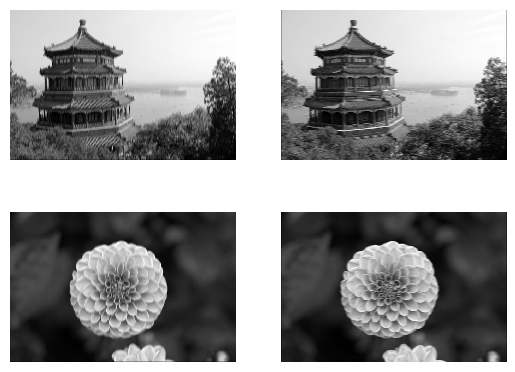

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

### Pooling layers

Max pooling layer - we can decrese size of image and there are various types of choosing best value: AVG, MAX \
Nowadays we mostly use MAX, since we keep only most important informations.

In [6]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [7]:
def crop(images):
    return images[150:220, 130:250]

In [8]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)

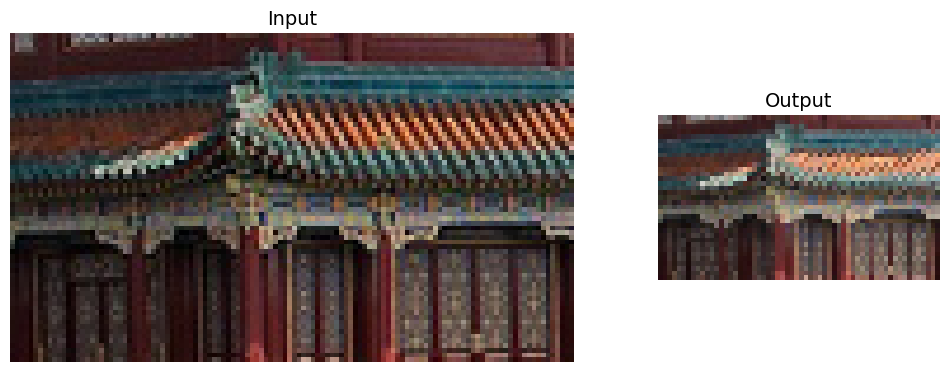

In [11]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Architecture of convolutional neutral networks

MNIST dataset

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [16]:
print(f"X_train {X_train.shape}")
print(f"X_valid {X_valid.shape}")
print(f"X_test {X_test.shape}")

X_train (55000, 28, 28, 1)
X_valid (5000, 28, 28, 1)
X_test (10000, 28, 28, 1)


In [17]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), #we choose preatty big filters (7) becaouse images are rather small
    keras.layers.MaxPooling2D(pool_size=2), #we change size of image /2
    DefaultConv2D(filters=128), #it is common to double numbers of filters after pooling layers with size 2 etc
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5), # in order to prevent overfitting we add droput layer 
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # fake new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 136s 78ms/step - loss: 0.7163 - accuracy: 0.7505 - val_loss: 0.3869 - val_accuracy: 0.8682
Epoch 2/10
1719/1719 [==============================] - 134s 78ms/step - loss: 0.4344 - accuracy: 0.8547 - val_loss: 0.3448 - val_accuracy: 0.8778
Epoch 3/10
1719/1719 [==============================] - 133s 78ms/step - loss: 0.3765 - accuracy: 0.8754 - val_loss: 0.3104 - val_accuracy: 0.8958
Epoch 4/10
1719/1719 [==============================] - 133s 77ms/step - loss: 0.3321 - accuracy: 0.8884 - val_loss: 0.3148 - val_accuracy: 0.8846
Epoch 5/10
1719/1719 [==============================] - 134s 78ms/step - loss: 0.3157 - accuracy: 0.8936 - val_loss: 0.2986 - val_accuracy: 0.8972
Epoch 6/10
1719/1719 [==============================] - 133s 77ms/step - loss: 0.2973 - accuracy: 0.8993 - val_loss: 0.2816 - val_accuracy: 0.8966
Epoch 7/10
1719/1719 [==============================] - 133s 78ms/step - loss: 0.2809 - accuracy: 0.9035 - val_loss: 0

### Using existing models

In [20]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 3s 0us/step


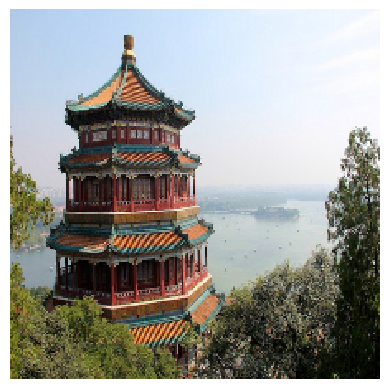

In [21]:
images_resized = tf.image.resize(images, [224, 224])    #specific model requires specific image format (remember to check it)
plot_color_image(images_resized[0])
plt.show()

In [22]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255) #we need to multiply by 255, since earlier we divide by 255
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 699ms/step


In [23]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image number {}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image number 0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image number 1
  n03530642 - honeycomb    49.81%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%

